# Stance Classification Visualization

Visualize stance distribution (favor, against, neutral) by party (pro ruling vs pro opposition).

**Features:**
- Grouped bar plots
- Stacked bar plots
- Per-keyword breakdown
- Automatic loading from temp files or final results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import glob
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Colors for stances
STANCE_COLORS = {
    'favor': '#2ecc71',     # Green
    'against': '#e74c3c',   # Red
    'neutral': '#95a5a6'    # Gray
}

PARTY_COLORS = {
    'pro ruling': '#FF6B35',      # Orange
    'pro opposition': '#004E89'   # Blue
}

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# ============================================================================
# DATA LOADING - Tries temp files first, falls back to final results
# ============================================================================

# Paths
TEMP_PATTERN = "/tmp/stance_parallel_*/outputs/result_*.csv"
FINAL_CSV = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/final_en_results/stance_results_37keywords.csv"

def load_stance_data():
    """Load stance results from temp files or final CSV."""
    
    # Try temp files first
    temp_files = glob.glob(TEMP_PATTERN)
    if temp_files:
        print(f"Loading from {len(temp_files)} temporary files...")
        dfs = [pd.read_csv(f) for f in sorted(temp_files)]
        df = pd.concat(dfs, axis=0, ignore_index=True)
        print(f"Loaded {len(df):,} rows from temp files")
    elif Path(FINAL_CSV).exists():
        print(f"Loading from final CSV: {FINAL_CSV}")
        df = pd.read_csv(FINAL_CSV)
        print(f"Loaded {len(df):,} rows")
    else:
        raise FileNotFoundError("No stance results found! Run inference first.")
    
    return df

df = load_stance_data()
print(f"\nColumns: {df.columns.tolist()}")

Loading from final CSV: /scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/final_en_results/stance_results_37keywords.csv
Loaded 311,099 rows

Columns: ['source_row', 'tweet', 'original_author', 'tweet_label', '_label_norm', 'keyword', 'subjects_scored', 'stance_gold', 'fewshot_raw', 'fewshot_label', 'fewshot_label_for_against', 'fewshot_reason', 'fewshot_shots_json']


In [3]:
# ============================================================================
# DATA PREPARATION
# ============================================================================

# Filter to only rows with valid stance labels
valid_stances = ['favor', 'against', 'neutral']
df_valid = df[df['fewshot_label'].isin(valid_stances)].copy()

print(f"Total rows: {len(df):,}")
print(f"Rows with valid stance labels: {len(df_valid):,}")
print(f"Rows pending inference: {len(df) - len(df_valid):,}\n")

# Rename for clarity
df_valid['stance'] = df_valid['fewshot_label']
df_valid['party'] = df_valid['_label_norm']

# Show distribution
print("=" * 50)
print("STANCE DISTRIBUTION")
print("=" * 50)
print(df_valid['stance'].value_counts())

print("\n" + "=" * 50)
print("PARTY DISTRIBUTION")
print("=" * 50)
print(df_valid['party'].value_counts())

Total rows: 311,099
Rows with valid stance labels: 311,099
Rows pending inference: 0

STANCE DISTRIBUTION
stance
favor      148050
against    107155
neutral     55894
Name: count, dtype: int64

PARTY DISTRIBUTION
party
pro ruling        188055
pro opposition    123044
Name: count, dtype: int64


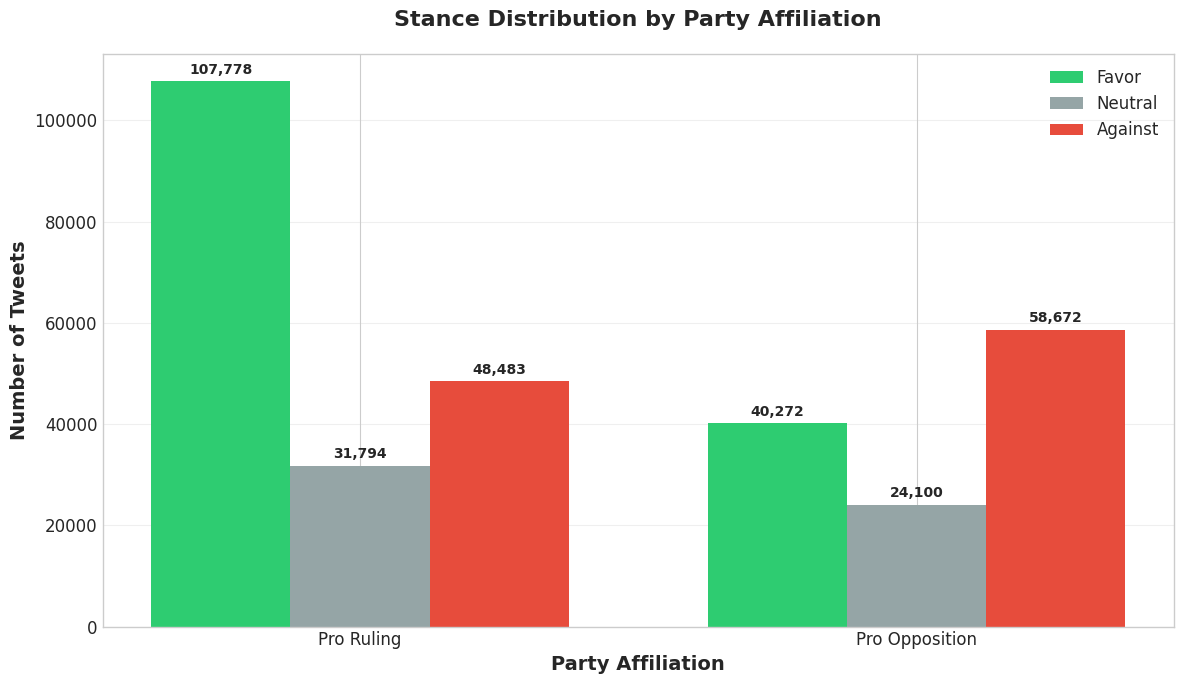

Saved: stance_by_party_grouped.png


In [4]:
# ============================================================================
# PLOT 1: Overall Stance Distribution by Party (Grouped Bar)
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

# Create cross-tabulation
ct = pd.crosstab(df_valid['party'], df_valid['stance'])
ct = ct.reindex(['pro ruling', 'pro opposition'])
ct = ct[['favor', 'neutral', 'against']]  # Order columns

# Plot grouped bar
x = np.arange(len(ct.index))
width = 0.25

bars1 = ax.bar(x - width, ct['favor'], width, label='Favor', color=STANCE_COLORS['favor'])
bars2 = ax.bar(x, ct['neutral'], width, label='Neutral', color=STANCE_COLORS['neutral'])
bars3 = ax.bar(x + width, ct['against'], width, label='Against', color=STANCE_COLORS['against'])

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

ax.set_xlabel('Party Affiliation', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Tweets', fontsize=14, fontweight='bold')
ax.set_title('Stance Distribution by Party Affiliation', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([p.title() for p in ct.index], fontsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('stance_by_party_grouped.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_by_party_grouped.png")

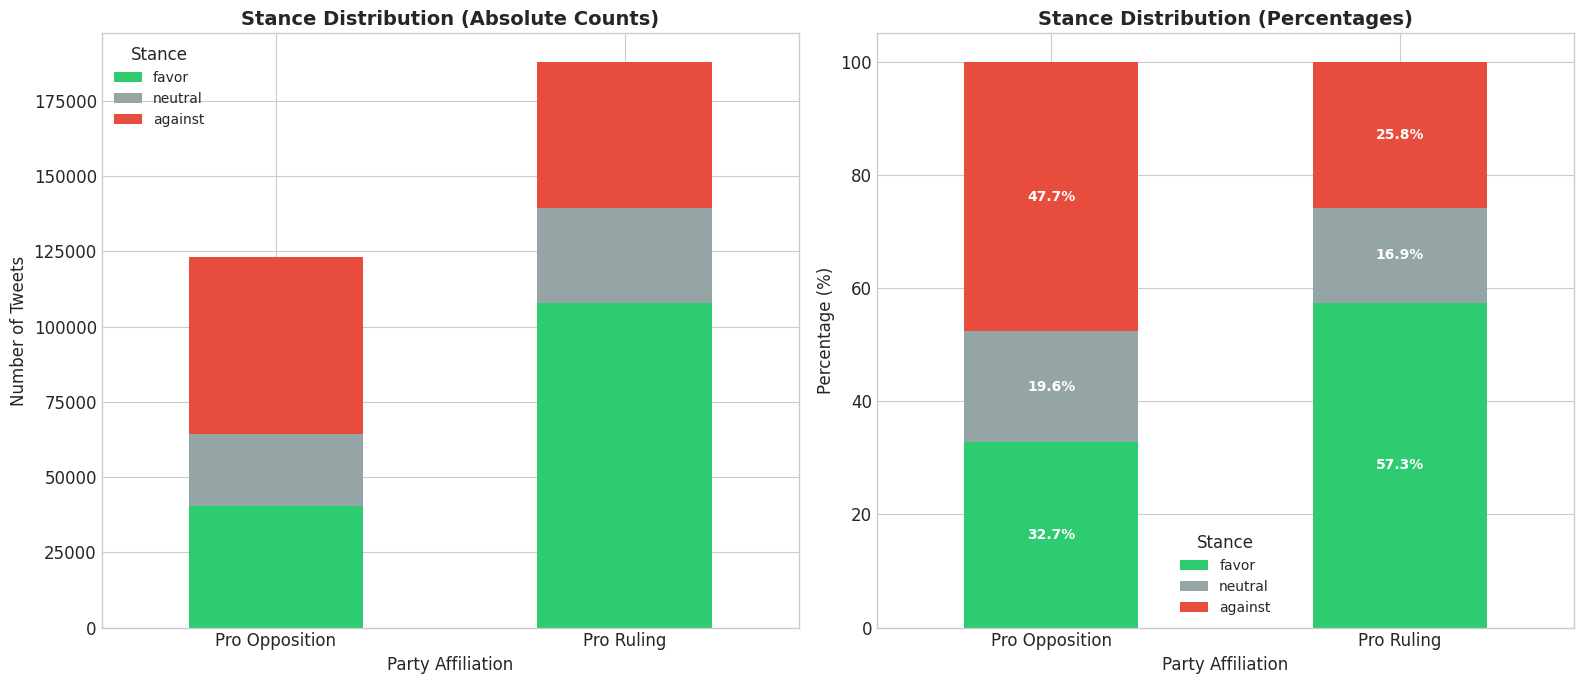

Saved: stance_by_party_stacked.png


In [5]:
# ============================================================================
# PLOT 2: Stacked Bar Chart (Proportions)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Absolute counts
ct = pd.crosstab(df_valid['party'], df_valid['stance'])
ct = ct[['favor', 'neutral', 'against']]
ct.plot(kind='bar', stacked=True, ax=axes[0], 
        color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']])
axes[0].set_title('Stance Distribution (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Party Affiliation', fontsize=12)
axes[0].set_ylabel('Number of Tweets', fontsize=12)
axes[0].set_xticklabels([p.title() for p in ct.index], rotation=0)
axes[0].legend(title='Stance', fontsize=10)

# Right: Proportions (normalized)
ct_norm = ct.div(ct.sum(axis=1), axis=0) * 100
ct_norm.plot(kind='bar', stacked=True, ax=axes[1],
             color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']])
axes[1].set_title('Stance Distribution (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Party Affiliation', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_xticklabels([p.title() for p in ct_norm.index], rotation=0)
axes[1].legend(title='Stance', fontsize=10)

# Add percentage labels
for i, party in enumerate(ct_norm.index):
    cumsum = 0
    for stance in ['favor', 'neutral', 'against']:
        val = ct_norm.loc[party, stance]
        if val > 5:  # Only show if > 5%
            axes[1].text(i, cumsum + val/2, f'{val:.1f}%', 
                        ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        cumsum += val

plt.tight_layout()
plt.savefig('stance_by_party_stacked.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_by_party_stacked.png")

Found 37 keywords


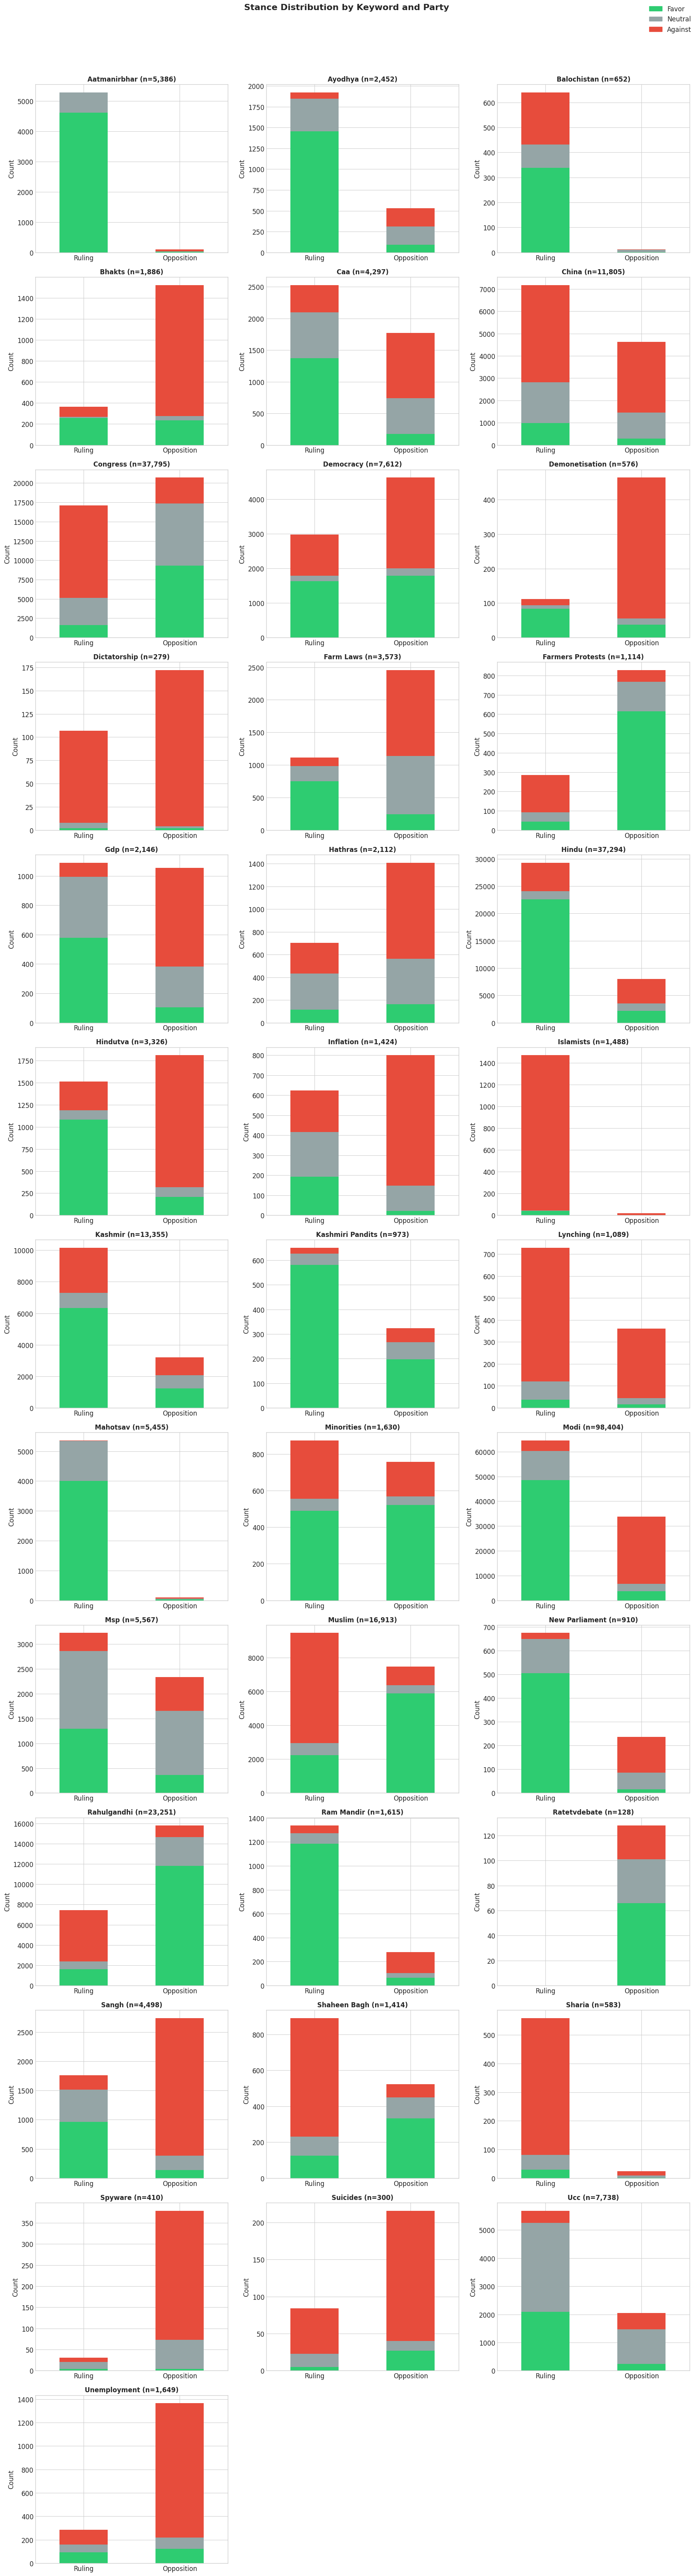

Saved: stance_by_keyword.png


In [6]:
# ============================================================================
# PLOT 3: Stance by Keyword (Faceted)
# ============================================================================

# Get unique keywords
keywords = df_valid['keyword'].unique()
n_keywords = len(keywords)
print(f"Found {n_keywords} keywords")

# Create grid
n_cols = 3
n_rows = (n_keywords + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, kw in enumerate(sorted(keywords)):
    ax = axes[i]
    kw_data = df_valid[df_valid['keyword'] == kw]
    
    # Cross-tab for this keyword
    ct = pd.crosstab(kw_data['party'], kw_data['stance'])
    ct = ct.reindex(['pro ruling', 'pro opposition'])
    for col in ['favor', 'neutral', 'against']:
        if col not in ct.columns:
            ct[col] = 0
    ct = ct[['favor', 'neutral', 'against']]
    
    # Plot
    ct.plot(kind='bar', stacked=True, ax=ax,
            color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']],
            legend=False)
    ax.set_title(f'{kw.title()} (n={len(kw_data):,})', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.set_xticklabels([p.replace('pro ', '').title() for p in ct.index], rotation=0)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add shared legend
handles = [plt.Rectangle((0,0),1,1, color=STANCE_COLORS[s]) for s in ['favor', 'neutral', 'against']]
fig.legend(handles, ['Favor', 'Neutral', 'Against'], loc='upper right', fontsize=12)

plt.suptitle('Stance Distribution by Keyword and Party', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('stance_by_keyword.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_by_keyword.png")

Found 37 keywords


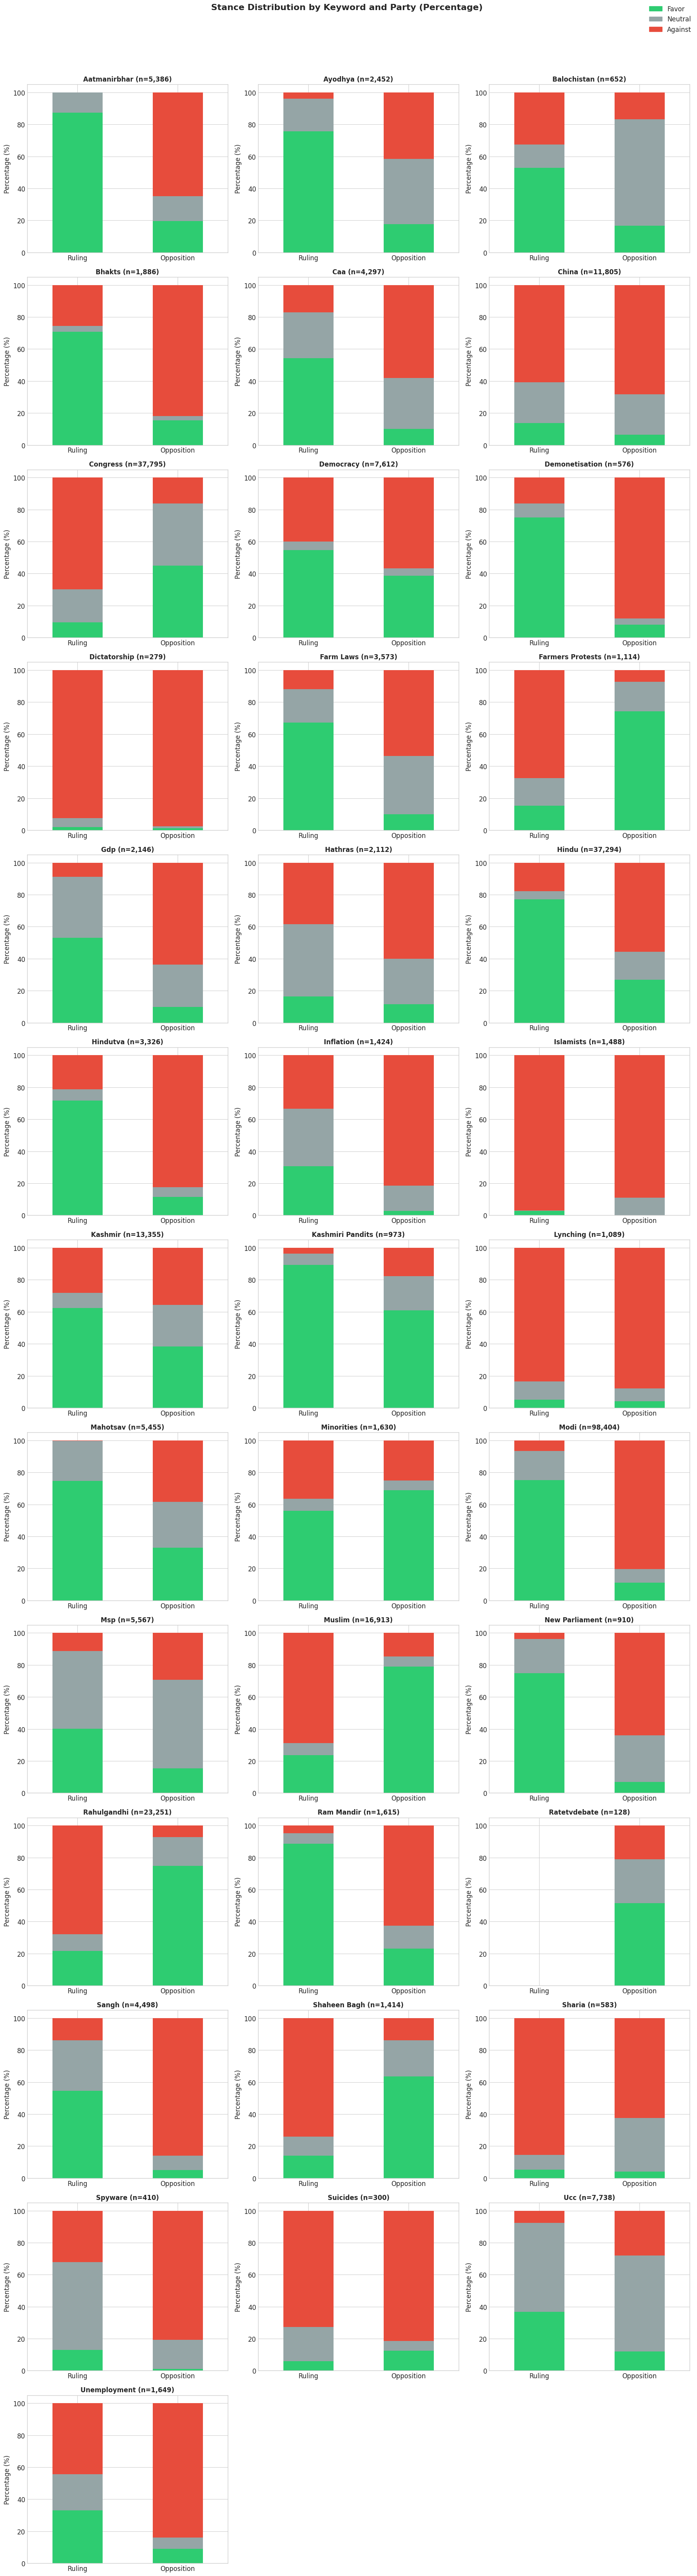

Saved: stance_by_keyword_pct.png


In [7]:
# ============================================================================
# PLOT 3b: Stance by Keyword (Faceted, Percentage)
# ============================================================================

# Get unique keywords
keywords = df_valid['keyword'].unique()
n_keywords = len(keywords)
print(f"Found {n_keywords} keywords")

# Create grid
n_cols = 3
n_rows = (n_keywords + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, kw in enumerate(sorted(keywords)):
    ax = axes[i]
    kw_data = df_valid[df_valid['keyword'] == kw]
    
    # Cross-tab for this keyword
    ct = pd.crosstab(kw_data['party'], kw_data['stance'], normalize='index') * 100
    ct = ct.reindex(['pro ruling', 'pro opposition'])
    for col in ['favor', 'neutral', 'against']:
        if col not in ct.columns:
            ct[col] = 0
    ct = ct[['favor', 'neutral', 'against']]
    
    # Plot
    ct.plot(kind='bar', stacked=True, ax=ax,
            color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']],
            legend=False)
    ax.set_title(f'{kw.title()} (n={len(kw_data):,})', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Percentage (%)')
    ax.set_xticklabels([p.replace('pro ', '').title() for p in ct.index], rotation=0)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add shared legend
handles = [plt.Rectangle((0,0),1,1, color=STANCE_COLORS[s]) for s in ['favor', 'neutral', 'against']]
fig.legend(handles, ['Favor', 'Neutral', 'Against'], loc='upper right', fontsize=12)

plt.suptitle('Stance Distribution by Keyword and Party (Percentage)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('stance_by_keyword_pct.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_by_keyword_pct.png")

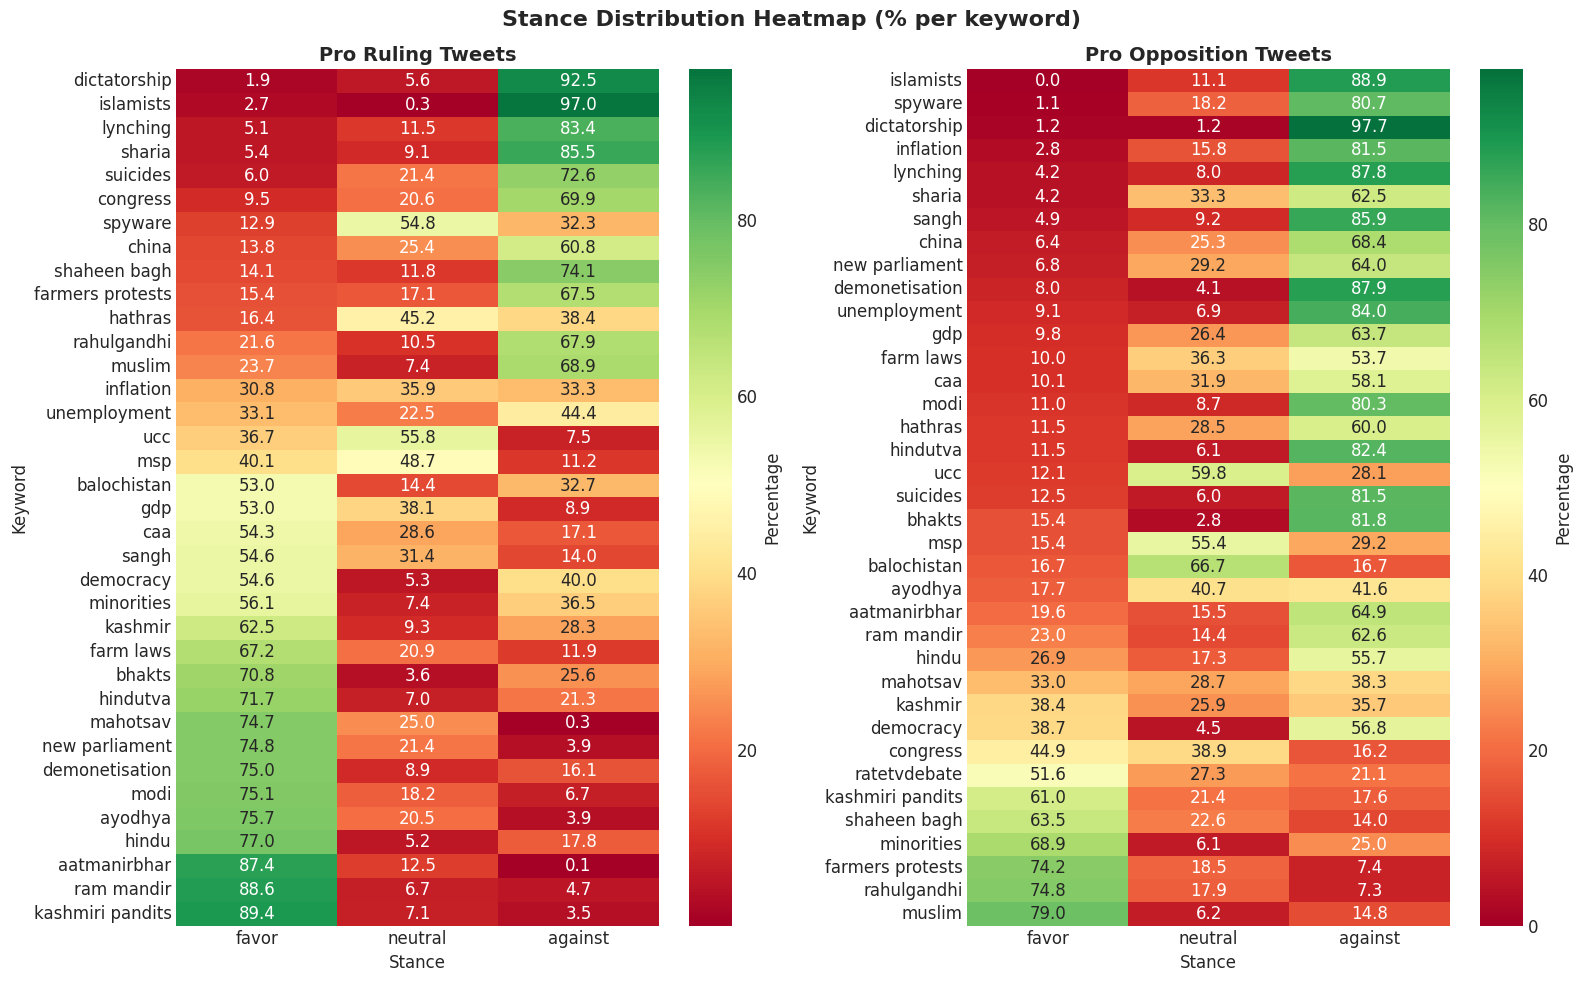

Saved: stance_heatmap.png


In [8]:
# ============================================================================
# PLOT 4: Heatmap of Stance Proportions by Keyword
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

for idx, party in enumerate(['pro ruling', 'pro opposition']):
    ax = axes[idx]
    party_data = df_valid[df_valid['party'] == party]
    
    # Create pivot table
    pivot = pd.crosstab(party_data['keyword'], party_data['stance'], normalize='index') * 100
    for col in ['favor', 'neutral', 'against']:
        if col not in pivot.columns:
            pivot[col] = 0
    pivot = pivot[['favor', 'neutral', 'against']]
    pivot = pivot.sort_values('favor', ascending=True)
    
    # Heatmap
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=50,
                ax=ax, cbar_kws={'label': 'Percentage'})
    ax.set_title(f'{party.title()} Tweets', fontsize=14, fontweight='bold')
    ax.set_xlabel('Stance', fontsize=12)
    ax.set_ylabel('Keyword', fontsize=12)

plt.suptitle('Stance Distribution Heatmap (% per keyword)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('stance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_heatmap.png")

In [9]:
# ============================================================================
# SUMMARY TABLE
# ============================================================================

print("=" * 80)
print("SUMMARY TABLE: Stance by Party and Keyword")
print("=" * 80)

summary = df_valid.groupby(['keyword', 'party', 'stance']).size().unstack(fill_value=0)
summary['total'] = summary.sum(axis=1)

# Calculate percentages
for stance in ['favor', 'against', 'neutral']:
    if stance in summary.columns:
        summary[f'{stance}_%'] = (summary[stance] / summary['total'] * 100).round(1)

print(summary.to_string())

# Save to CSV
summary.to_csv('stance_summary.csv')
print("\nSaved: stance_summary.csv")

SUMMARY TABLE: Stance by Party and Keyword
stance                           against  favor  neutral  total  favor_%  against_%  neutral_%
keyword          party                                                                        
aatmanirbhar     pro opposition       63     19       15     97     19.6       64.9       15.5
                 pro ruling            7   4623      659   5289     87.4        0.1       12.5
ayodhya          pro opposition      221     94      216    531     17.7       41.6       40.7
                 pro ruling           74   1454      393   1921     75.7        3.9       20.5
balochistan      pro opposition        2      2        8     12     16.7       16.7       66.7
                 pro ruling          209    339       92    640     53.0       32.7       14.4
bhakts           pro opposition     1246    234       43   1523     15.4       81.8        2.8
                 pro ruling           93    257       13    363     70.8       25.6        3.6
caa    

In [10]:
# ============================================================================
# INFERENCE PROGRESS CHECK
# ============================================================================

total_rows = len(df)
completed_rows = len(df_valid)
pending_rows = total_rows - completed_rows
progress_pct = completed_rows / total_rows * 100

print("=" * 50)
print("INFERENCE PROGRESS")
print("=" * 50)
print(f"Total rows:     {total_rows:,}")
print(f"Completed:      {completed_rows:,} ({progress_pct:.1f}%)")
print(f"Pending:        {pending_rows:,}")
print("=" * 50)

# Progress bar visualization
bar_length = 40
filled = int(bar_length * progress_pct / 100)
bar = '█' * filled + '░' * (bar_length - filled)
print(f"\n[{bar}] {progress_pct:.1f}%")

INFERENCE PROGRESS
Total rows:     311,099
Completed:      311,099 (100.0%)
Pending:        0

[████████████████████████████████████████] 100.0%


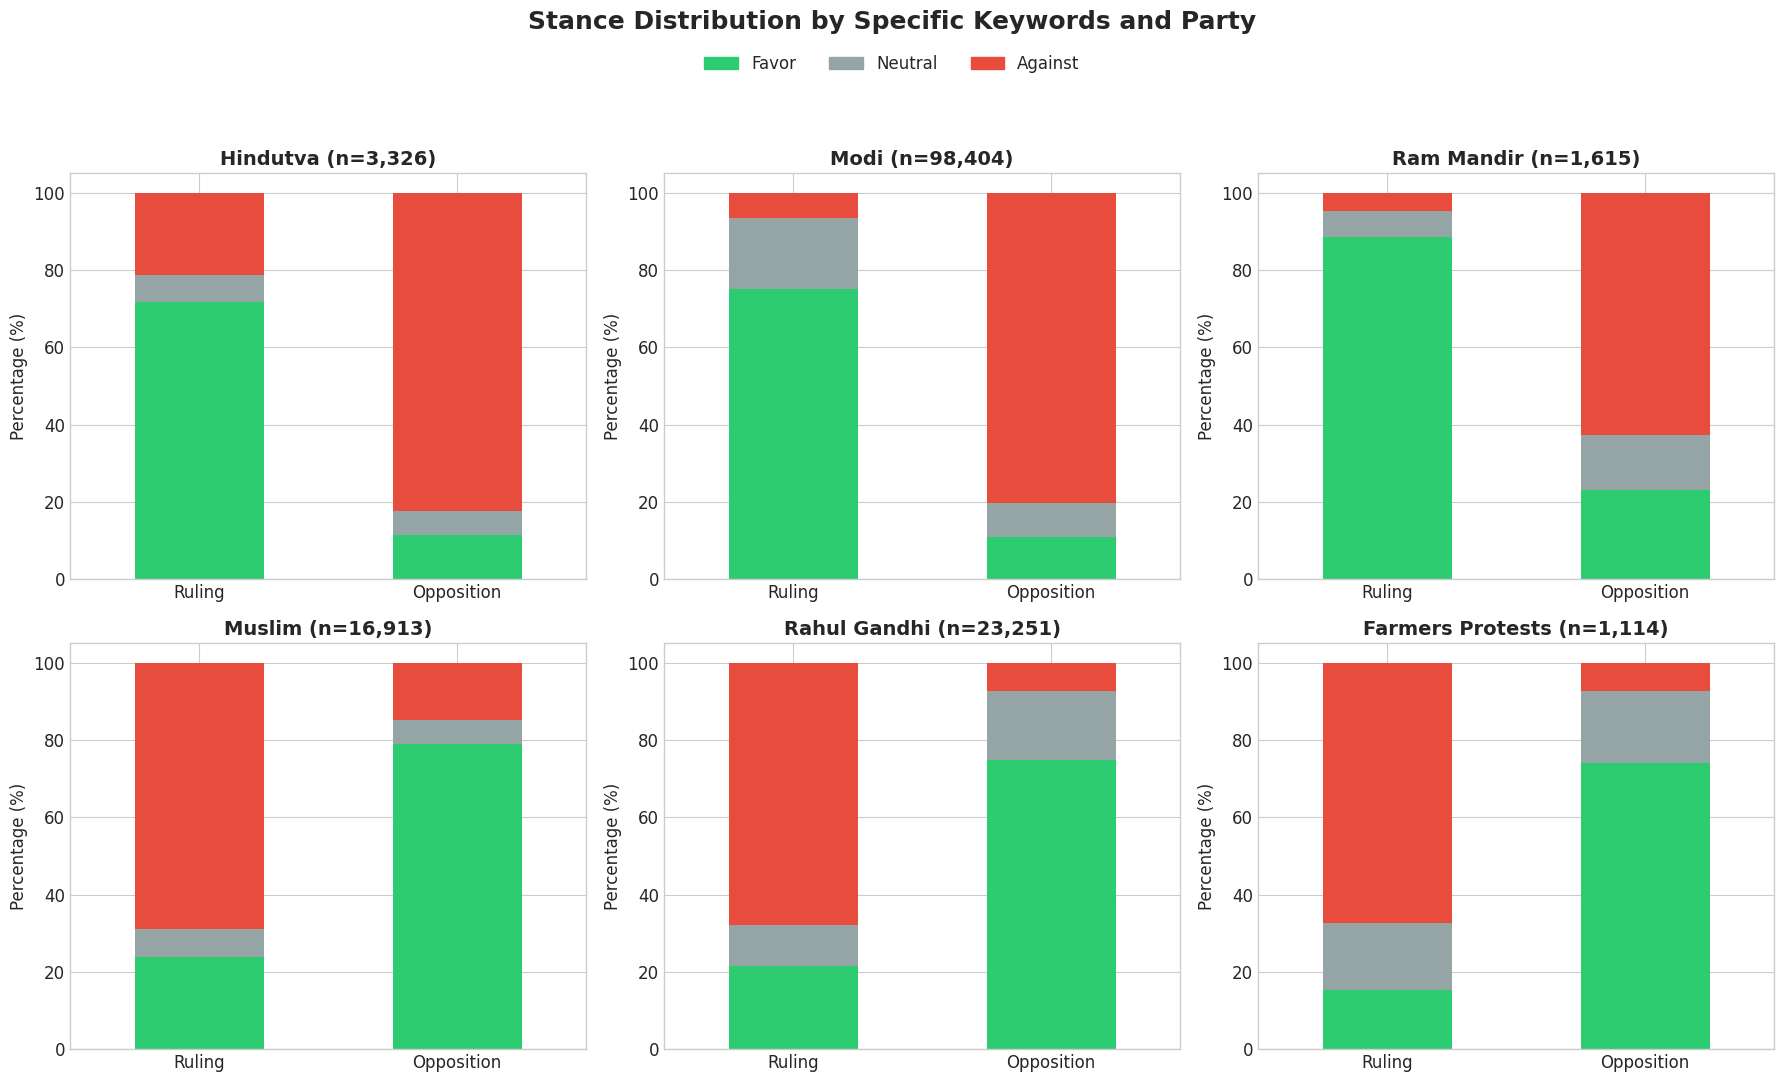

Generated 2x3 grid for: Hindutva, Modi, Ram Mandir, Muslim, Rahulgandhi, Farmers Protests


In [12]:
# ============================================================================
# PLOT 3b: Stance by Keyword (Faceted, Percentage) - Specific 2x3 Grid
# ============================================================================

# Define your target keywords and grid structure
target_keywords = ['Hindutva', 'Modi', 'Ram Mandir', 'Muslim', 'Rahulgandhi', 'Farmers Protests']
n_cols = 3
n_rows = 2

# Filter data for only these keywords (case-insensitive check to be safe)
df_filtered = df_valid[df_valid['keyword'].str.lower().isin([k.lower() for k in target_keywords])]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.flatten()

# Iterate through your specific list to maintain the 2x3 order
for i, kw in enumerate(target_keywords):
    ax = axes[i]
    
    # Filter data for this specific keyword
    kw_data = df_filtered[df_filtered['keyword'].str.lower() == kw.lower()]
    
    if kw_data.empty:
        ax.text(0.5, 0.5, f'No data for "{kw}"', ha='center')
        ax.set_title(f'{kw}')
        continue

    # Cross-tab for this keyword
    ct = pd.crosstab(kw_data['party'], kw_data['stance'], normalize='index') * 100
    
    # Ensure both parties are present for comparison
    ct = ct.reindex(['pro ruling', 'pro opposition']).fillna(0)
    
    # Ensure all stance columns exist
    for col in ['favor', 'neutral', 'against']:
        if col not in ct.columns:
            ct[col] = 0
    ct = ct[['favor', 'neutral', 'against']]
    
    # Plot
    ct.plot(kind='bar', stacked=True, ax=ax,
            color=[STANCE_COLORS['favor'], STANCE_COLORS['neutral'], STANCE_COLORS['against']],
            legend=False)
    
    ax.set_title(f'{kw.replace("Rahulgandhi", "Rahul Gandhi").title()} (n={len(kw_data):,})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 105) # Extra space for clarity
    
    # Clean up x-axis labels: 'pro ruling' -> 'Ruling', 'pro opposition' -> 'Opposition'
    ax.set_xticklabels([p.replace('pro ', '').title() for p in ct.index], rotation=0)

# Add shared legend
handles = [plt.Rectangle((0,0),1,1, color=STANCE_COLORS[s]) for s in ['favor', 'neutral', 'against']]
fig.legend(handles, ['Favor', 'Neutral', 'Against'], 
           loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=12)

plt.suptitle('Stance Distribution by Specific Keywords and Party', fontsize=18, fontweight='bold', y=1.08)
plt.tight_layout()

# Save and Show
plt.savefig('stance_2x3_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Generated 2x3 grid for: {', '.join(target_keywords)}")

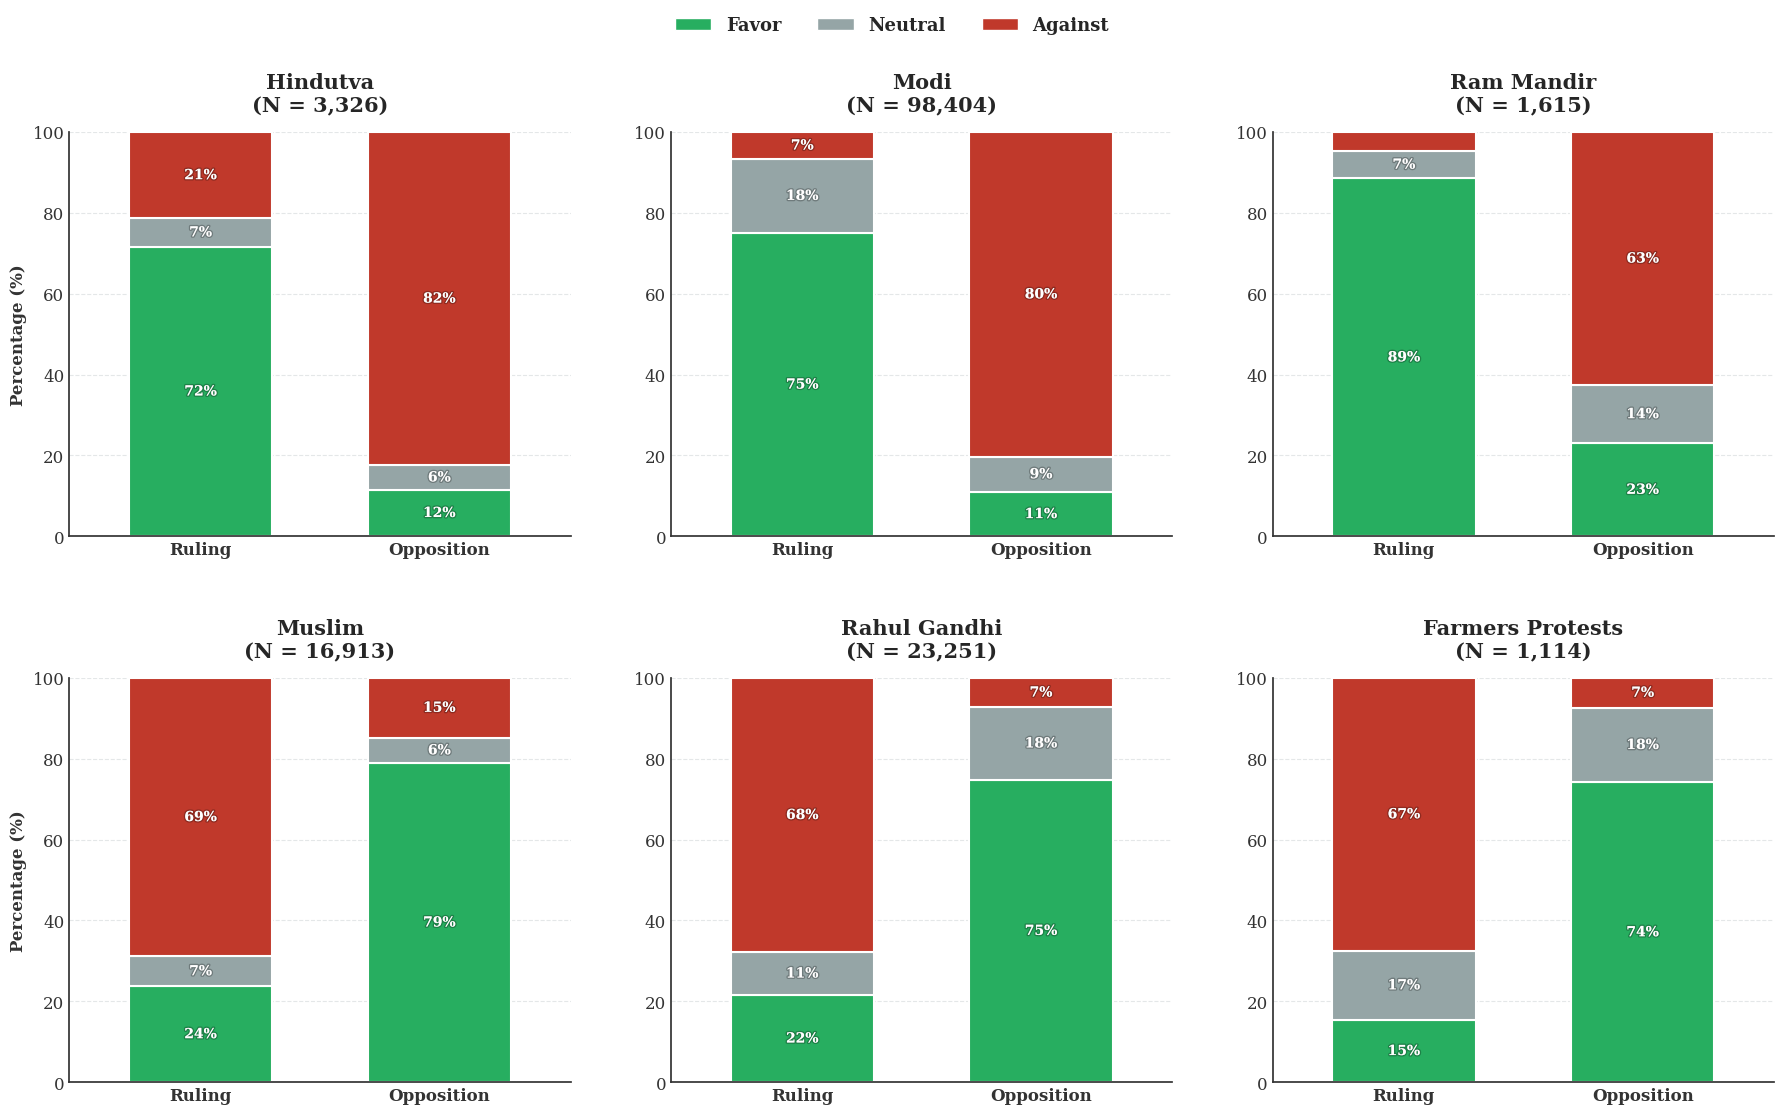

Publication-ready plot saved to: stance_academic_fancy_fixed.png


In [18]:
# ============================================================================
# ACADEMIC PUBLICATION PLOT: Stance by Keyword (Red/Green/Neutral)
# ============================================================================
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

# --- 1. Publication-Quality Styling ---
plt.style.use('seaborn-v0_8-white')

# Set serif fonts for academic standards (e.g., Times New Roman)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'axes.edgecolor': '#333333',
    'axes.labelcolor': '#333333',
    'xtick.color': '#333333',
    'ytick.color': '#333333'
})

# Refined Red-Green-Grey Palette
PUB_COLORS = {
    'favor':   '#27ae60',  # Emerald Green
    'neutral': '#95a5a6',  # Slate Grey
    'against': '#c0392b'   # Crimson Red
}

# --- 2. Data Setup ---
target_keywords = ['Hindutva', 'Modi', 'Ram Mandir', 'Muslim', 'Rahulgandhi', 'Farmers Protests']
n_cols = 3
n_rows = 2

# Filter data (case-insensitive)
df_filtered = df_valid[df_valid['keyword'].str.lower().isin([k.lower() for k in target_keywords])]

# Create figure with high-quality sizing
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 11), facecolor='white')
axes = axes.flatten()

# --- 3. Plotting Loop ---
for i, kw in enumerate(target_keywords):
    ax = axes[i]
    kw_data = df_filtered[df_filtered['keyword'].str.lower() == kw.lower()]

    if kw_data.empty:
        ax.set_axis_off()
        continue

    # Cross-tab normalized to 100%
    ct = pd.crosstab(kw_data['party'], kw_data['stance'], normalize='index') * 100
    ct = ct.reindex(['pro ruling', 'pro opposition']).fillna(0)
    for col in ['favor', 'neutral', 'against']:
        if col not in ct.columns: ct[col] = 0
    ct = ct[['favor', 'neutral', 'against']]

    # Plot stacked bars with white edges for depth/separation
    bars = ct.plot(kind='bar', stacked=True, ax=ax,
                   color=[PUB_COLORS['favor'], PUB_COLORS['neutral'], PUB_COLORS['against']],
                   legend=False, width=0.6, edgecolor='white', linewidth=1.5)

    # --- 4. Fancy Labeling with "3D" Shadow Depth ---
    for bar_group in bars.containers:
        for bar in bar_group:
            height = bar.get_height()
            if height > 5:  # Only label visible segments
                x_pos = bar.get_x() + bar.get_width() / 2
                y_pos = bar.get_y() + height / 2
                
                # Text with a subtle black "halo" for readability and depth
                txt = ax.text(x_pos, y_pos, f'{height:.0f}%', 
                               ha='center', va='center',
                               color='white', fontweight='bold', fontsize=10)
                
                # Numeric tuple (R, G, B, Alpha) avoids the CSS string error
                txt.set_path_effects([
                    path_effects.withStroke(linewidth=2, foreground=(0, 0, 0, 0.25))
                ])

    # --- 5. Axis & Title Refinement ---
    clean_title = kw.replace("Rahulgandhi", "Rahul Gandhi").title()
    ax.set_title(f'{clean_title}\n(N = {len(kw_data):,})', 
                 fontsize=15, fontweight='bold', pad=15)
    
    ax.set_ylim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage (%)' if i % 3 == 0 else '', fontsize=12, fontweight='bold')
    
    # Tick Label Cleanup
    ax.set_xticklabels(['Ruling', 'Opposition'], rotation=0, fontsize=12, fontweight='bold')
    
    # Elegant grid (horizontal only)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4, color='#bdc3c7')
    ax.set_axisbelow(True)
    
    # Professional spine removal
    sns.despine(ax=ax, top=True, right=True)

# --- 6. Global Legend & Final polish ---
legend_elements = [
    Patch(facecolor=PUB_COLORS['favor'], edgecolor='white', label='Favor'),
    Patch(facecolor=PUB_COLORS['neutral'], edgecolor='white', label='Neutral'),
    Patch(facecolor=PUB_COLORS['against'], edgecolor='white', label='Against')
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02),
           ncol=3, fontsize=14, frameon=False, prop={'family': 'serif', 'weight': 'bold'})

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.35, wspace=0.2)

# Save at 300 DPI for publication
save_path = 'stance_academic_fancy_fixed.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Publication-ready plot saved to: {save_path}")

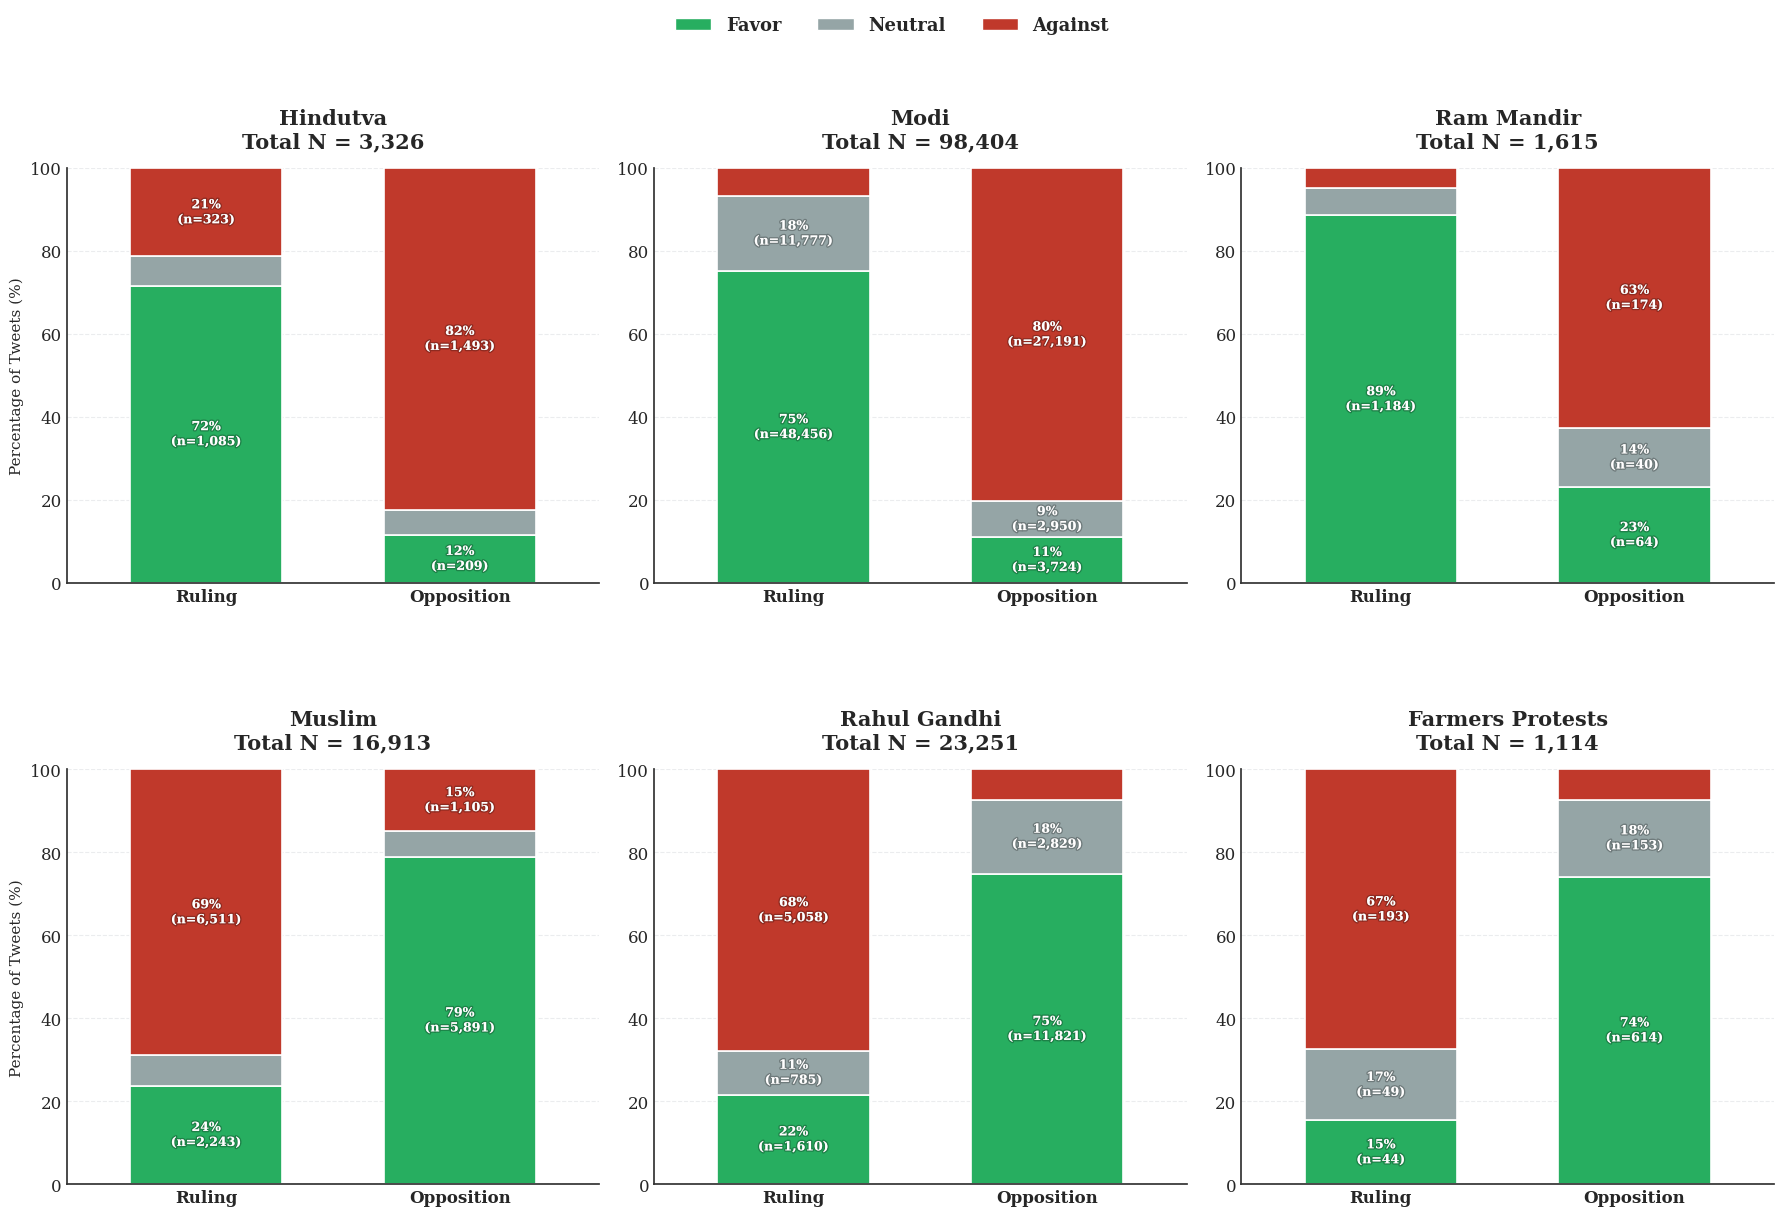

Detailed plot with counts saved to: stance_academic_counts_included.png


In [19]:
# ============================================================================
# ACADEMIC PUBLICATION PLOT: Stance with Percentages AND Counts
# ============================================================================
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

# --- 1. Publication-Quality Styling ---
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'axes.edgecolor': '#333333'
})

PUB_COLORS = {
    'favor':   '#27ae60',  # Emerald Green
    'neutral': '#95a5a6',  # Slate Grey
    'against': '#c0392b'   # Crimson Red
}

# --- 2. Data Setup ---
target_keywords = ['Hindutva', 'Modi', 'Ram Mandir', 'Muslim', 'Rahulgandhi', 'Farmers Protests']
n_cols = 3
n_rows = 2

df_filtered = df_valid[df_valid['keyword'].str.lower().isin([k.lower() for k in target_keywords])]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), facecolor='white')
axes = axes.flatten()

# --- 3. Plotting Loop ---
for i, kw in enumerate(target_keywords):
    ax = axes[i]
    kw_data = df_filtered[df_filtered['keyword'].str.lower() == kw.lower()]

    if kw_data.empty:
        ax.set_axis_off()
        continue

    # A. Calculate Percentages for plotting
    ct_pct = pd.crosstab(kw_data['party'], kw_data['stance'], normalize='index') * 100
    ct_pct = ct_pct.reindex(['pro ruling', 'pro opposition']).fillna(0)
    
    # B. Calculate Absolute Counts for labels
    ct_counts = pd.crosstab(kw_data['party'], kw_data['stance'])
    ct_counts = ct_counts.reindex(['pro ruling', 'pro opposition']).fillna(0)

    # Ensure all columns exist in both
    for col in ['favor', 'neutral', 'against']:
        if col not in ct_pct.columns: ct_pct[col] = 0
        if col not in ct_counts.columns: ct_counts[col] = 0
    
    # Order columns
    ct_pct = ct_pct[['favor', 'neutral', 'against']]
    ct_counts = ct_counts[['favor', 'neutral', 'against']]

    # Plot stacked bars
    bars = ct_pct.plot(kind='bar', stacked=True, ax=ax,
                       color=[PUB_COLORS['favor'], PUB_COLORS['neutral'], PUB_COLORS['against']],
                       legend=False, width=0.6, edgecolor='white', linewidth=1.2)

    # --- 4. Annotation Logic: Pct + (n=Count) ---
    # stance_list helps map the container index back to the column name
    stance_list = ['favor', 'neutral', 'against']
    party_list = ['pro ruling', 'pro opposition']

    for container_idx, bar_group in enumerate(bars.containers):
        stance_name = stance_list[container_idx]
        
        for bar_idx, bar in enumerate(bar_group):
            height = bar.get_height()
            party_name = party_list[bar_idx]
            count = int(ct_counts.loc[party_name, stance_name])
            
            # Increased threshold to 8% so the text doesn't overflow small segments
            if height > 8: 
                x_pos = bar.get_x() + bar.get_width() / 2
                y_pos = bar.get_y() + height / 2
                
                # Format: "75%\n(n=1,234)"
                label_text = f'{height:.0f}%\n(n={count:,})'
                
                txt = ax.text(x_pos, y_pos, label_text, 
                               ha='center', va='center',
                               color='white', fontweight='bold', fontsize=9,
                               linespacing=1.2)
                
                # Depth shadow for readability
                txt.set_path_effects([
                    path_effects.withStroke(linewidth=2, foreground=(0, 0, 0, 0.25))
                ])

    # --- 5. Clean up Axes ---
    clean_title = kw.replace("Rahulgandhi", "Rahul Gandhi").title()
    ax.set_title(f'{clean_title}\nTotal N = {len(kw_data):,}', 
                 fontsize=15, fontweight='bold', pad=15)
    
    ax.set_ylim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Tweets (%)' if i % 3 == 0 else '', fontsize=11)
    ax.set_xticklabels(['Ruling', 'Opposition'], rotation=0, fontsize=12, fontweight='bold')
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='#bdc3c7')
    sns.despine(ax=ax, top=True, right=True)

# --- 6. Legend & Title ---
legend_elements = [Patch(facecolor=PUB_COLORS[s], edgecolor='white', label=s.title()) 
                   for s in ['favor', 'neutral', 'against']]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02),
           ncol=3, fontsize=14, frameon=False, prop={'family': 'serif', 'weight': 'bold'})

plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.45)

# Save
save_name = 'stance_academic_counts_included.png'
plt.savefig(save_name, dpi=300, bbox_inches='tight')
plt.show()

print(f"Detailed plot with counts saved to: {save_name}")